ç

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import xgboost as xgb
training = pd.read_csv("training.csv")
offer= pd.read_csv('offers.csv')
pd.set_option("display.max_columns", None)


training.fillna(value = {'Depth':training.Depth.mean(), 'Table':training.Table.mean()}, inplace=True)
offer.fillna(value = {'Depth':offer.Depth.mean(), 'Table':offer.Table.mean()}, inplace=True)
offer2 = offer
training['Polish'] = np.where(training['Polish']== ' ', training['Polish'].mode(), training['Polish'])

training['Shape']=np.where(training['Shape'] == 'ROUND', 'Round', training['Shape'])
offer['Shape']=np.where(offer['Shape'] == 'ROUND', 'Round', offer['Shape'])

training['Regions']=np.where(training['Regions'] == 'Other/Unknown', 
                             training['Regions'].mode(), training['Regions'])
offer['Regions']=np.where(offer['Regions'] == 'Other/Unknown', 
                          offer['Regions'].mode(), offer['Regions'])

training['Symmetry']=np.where(training['Symmetry'] == ' ', training['Symmetry'].mode(), 
                              np.where(training['Symmetry'] == 'Execllent', 'Excellent', training['Symmetry']))

offer['Symmetry']=np.where(offer['Symmetry'] == ' ', offer['Symmetry'].mode(), offer['Symmetry'])


mode = training['Cert'].mode().values[0]
training['Cert'].fillna(value=mode, inplace=True)
mode2 = offer['Cert'].mode().values[0]
offer['Cert'].fillna(value=mode2, inplace=True)

mode3 = offer['Known_Conflict_Diamond'].mode().values[0]
offer['Known_Conflict_Diamond'].fillna(value = mode3, inplace=True)

In [2]:
training['Vendor'] = training.Vendor.astype(str)

Here, i started subsetting thwe dataset for prediction. i removed id, cut, retail, price and log retail as they wonnt be needed for the supposed machine learning. to reiterate, cut was removed because over 60% of the data is missing and filling it up wont have a good representation of the entire sample.

from the observaiton, logprice was used this is because one rule of regession is that the dataset has to be normally distributed. but price and retail price are skewed to the right and so, log of the price is used.after the prediction, the predicted price which is still in log is transformed with actual value. 

In [3]:
cleaned = training.drop(columns = ["id","Cut", "Retail", "Price", "LogRetail"])

offer_cleaned = offer.drop(columns = ["id","Cut", "Offers"])

In [4]:
target = cleaned["LogPrice"]
target
predictors= cleaned.drop(columns=["LogPrice"])


from the dataset it is obverse that some categorical data has  lots of various levels are categories. labelling this columns as 0,1 wont work as it contains lots of categories and the model might see them as integers annd wont perform optimally to get better prediction and model accuracy. so what is the way out? "one hot encoding". one hot encoding is a method of coverting categorical values into a new categorical column and assign a binary value of 1 or 0 to these columns. 

In [5]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(predictors)
categorical_columns = categorical_columns_selector(predictors)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])


####offer one-hot-encoder
numerical_columns_selector_offer = selector(dtype_exclude=object)
categorical_columns_selector_offer = selector(dtype_include=object)

numerical_columns_offer = numerical_columns_selector_offer(offer_cleaned)
categorical_columns_offer = categorical_columns_selector_offer(offer_cleaned)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
   ('one-hot-encoder', categorical_preprocessor, categorical_columns_offer),
   ('standard_scaler', numerical_preprocessor, numerical_columns_offer)])

In [6]:
rfr = make_pipeline(preprocessor, RandomForestRegressor())

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    predictors, target, random_state=42)

In [8]:
rfr.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Cert', 'Clarity', 'Color',
                                                   'Measurements', 'Polish',
                                                   'Regions', 'Shape',
                                                   'Symmetry']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Carats', 'Depth',
                                                   'Known_Conflict_Diamond',
                                                   'Table', 'Vendor'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [12]:
y_pred = rfr.predict(offer_cleaned)
y_pred

array([ 6.37404856,  6.38106699,  6.38036367, ..., 10.00901771,
       11.6394963 ,  8.62433224])

In [14]:
rfr.score(x_train, y_train)

0.9970887385249395

In [10]:
offer['Offers'] = y_pred
offer['Offers'] = np.exp(offer['Offers'])

NameError: name 'y_pred' is not defined

since i want to select from the predicted offer, i have to create a justification for my selection. to do that, i have to predict the Retailprice as well and find the growth rate difference between the price and the retail price. after which i will sort the column by descending order to enable me select the rows and ensure my offer is less than 5,000,000. 

## RetailPrice prediction
from the observation, you will notice that logretail was also used to get the predicted value of retailprice

In [387]:
cleaned2 = training.drop(columns = ["id","Cut", "Retail", "Price", "LogPrice"])
offer['Vendor'] = offer.Vendor.astype(str)
retail_cleaned = offer.drop(columns = ["id","Cut", "Offers"])
retail_cleaned
cleaned
target_retail = cleaned2["LogRetail"]
predcitors_retail = cleaned2.drop(columns=["LogRetail"])

numerical_columns_selector_retail = selector(dtype_exclude=object)
categorical_columns_selector_retail = selector(dtype_include=object)

numerical_columns_retail = numerical_columns_selector_retail(predictors_retail)
categorical_columns_retail = categorical_columns_selector_retail(predictors_retail)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor_retail = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns_retail),
    ('standard_scaler', numerical_preprocessor, numerical_columns_retail)])

In [169]:
rfrr = make_pipeline(preprocessor_retail, RandomForestRegressor())

In [388]:
x_train_retail, x_test_retail, y_train_retail, y_test_retail = train_test_split(
    predictors_retail, target_retail, random_state=42)

In [389]:
rfrr.fit(x_train_retail, y_train_retail)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Cert', 'Clarity', 'Color',
                                                   'Measurements', 'Polish',
                                                   'Regions', 'Shape',
                                                   'Symmetry', 'Vendor']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Carats', 'Depth',
                                                   'Known_Conflict_Diamond',
                                                   'Table'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [390]:
rfrr.score(x_test_retail, y_test_retail)

0.9728831513146663

In [391]:
retail_pred = rfrr.predict(retail_cleaned)

In [392]:
offer['RetailPrice'] = retail_pred
offer['RetailPrice'] = np.exp(offer['RetailPrice'])

In [393]:
offer1 = pd.DataFrame(offer)

here, i substracted the predicted price from the predicted retailprice then multipled it by the predicted price to get the actual rate/percentage which is a true estimate of the price.. if i had used just the diff between predicted price and predicted retailprice, the value wont represent the actual difference rate.

In [394]:
offer1['profit']= (offer1['RetailPrice'] - offer1['Offers'])/offer1['Offers']

In [395]:
offer_growth = offer1.sort_values(by=['profit'], ascending=False)

since i have a price constraint of 5,000,000,i have to employ the use of loop to ensure that my total predicted price is not more than 5,000,000

In [396]:
selected = 0
count = 0
budget = 4990756.903125745
for x in offer_growth['Offers']:
    selected += x
    count +=1
    if selected == budget:
        break 

In [397]:
my_offers = offer_growth.iloc[:620, :]

lastly, i used a merge function to fix my prediction in the orignal offer document. 

In [399]:
offer3 = offer2.drop(columns = ["Offers"])
offer3 = pd.DataFrame(offer3)
my_offer2 = my_offers[['id','Offers']]
my_offer2 = pd.DataFrame(my_offer2)

In [400]:
final_offer = pd.merge(offer3, my_offer2, how='left')

,id,Carats,Cert,Clarity,Color,Cut,Depth,Known_Conflict_Diamond,Measurements,Polish,Regions,Shape,Symmetry,Table,Vendor,RetailPrice,profit,Offers
0,8051,0.42,AGSL,SI2,L,,62.700000,False,4.81x4.78x3.01,Excellent,Australia,Round,Excellent,57.000000,1,950.126925,0.603476,NaN
1,8052,0.40,GemEx,VS2,M,,63.800000,False,4.64x4.61x2.95,Excellent,Australia,Round,Excellent,59.000000,1,943.947796,0.630525,NaN
2,8053,0.41,AGSL,SI2,L,,62.200000,True,4.76x4.74x2.95,Excellent,DR Congo,Round,Very good,58.000000,1,118.859820,-0.800633,NaN
3,8054,0.40,AGSL,SI1,K,,64.200000,False,4.63x4.59x2.96,Very good,Angola,Emerald,Very good,58.000000,1,898.241287,0.379981,NaN
4,8055,0.40,AGSL,VS2,L,,64.300000,False,4.67x4.62x2.99,Excellent,Russia,Round,Very good,58.104324,1,943.378085,0.585112,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,10729,1.65,AGSL,VS1,E,Excellent,58.400000,False,7.79x7.83x4.56,Excellent,Canada,Pear,Excellent,60.000000,4,37564.831487,0.306380,NaN
2679,10730,2.35,AGSL,SI2,E,Excellent,62.100000,True,8.48x8.53x5.28,Excellent,Angola,Round,Excellent,58.000000,2,4537.574374,-0.871937,NaN
2680,10731,2.35,AGSL,SI2,J,Excellent,61.781656,False,8.64x8.67x5.2,Excellent,Russia,Pear,Very good,58.104324,2,35508.073094,0.628014,NaN
2681,10732,5.02,AGSL,I1,J,Excellent,59.500000,False,11.16x11.18x6.64,Excellent,Russia,Oval,Excellent,59.000000,2,186142.860581,0.520539,NaN


In [362]:
final_offer.to_csv(r'C:\Users\ebukaezenwafor\Desktop\export_dataframe.csv', index = False, header=True)

In [ ]:
training.to_csv(r'C:\Users\ebukaezenwafor\Desktop\training

In [3]:
training.to_csv(r'C:\Users\ebukaezenwafor\Desktop\training_clean.csv', index = False, header=True)


### questions ( A and B)
a) from the chart, the vendors are selling relatively at a competitive price. 
b) there is a positive correlation between carats and retail price sp to say that the higher the carat, the greater the price of the daimond. it is a natural phenomenon as daimond are sold based on their carat. 

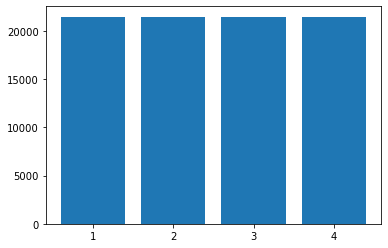

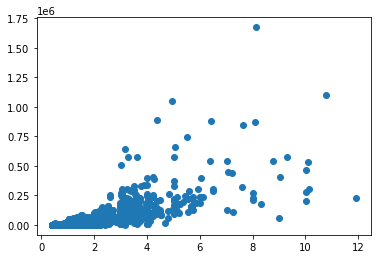

In [417]:
plt.bar(training['Vendor'], training['Retail'].mean())
plt.show()

plt.plot(training['Carats'], training['Retail'], 'o')
plt.show()